In [20]:
## for data
import pandas as pd  #1.1.5
import numpy as np  #1.21.0

## for plotting
import matplotlib.pyplot as plt  #3.3.2
import seaborn as sns  #0.11.1
import folium  #0.14.0
from folium import plugins
import plotly.express as px  #5.1.0

## for simple routing
import osmnx as ox  #1.2.2
import networkx as nx  #3.0


## for advanced routing 
from ortools.constraint_solver import pywrapcp  #9.6
from ortools.constraint_solver import routing_enums_pb2

In [21]:
#importing farm location data
farm_data=pd.read_excel('farm.xlsx')
farm_data=farm_data[['company','latitude','longitude']]
farm_data= farm_data.reset_index().rename(columns={"index":"id","company":"location", "latitude":"y", "longitude":"x"})
farm_data

,id,location,y,x
0,0,Htsfarms.ng - Agricultural online store,9.086603,7.443278


In [22]:
#importing store drop off location data
store_data=pd.read_excel('drops.xlsx')
store_data=store_data[['store','latitude','longitude']].reset_index().rename(columns={"index":"id","store":"location", "latitude":"y", "longitude":"x"})
store_data.head()

,id,location,y,x
0,0,a,9.093711,7.443353
1,1,b,9.103119,7.442881
2,2,c,9.105365,7.451936
3,3,d,9.073794,7.432667
4,4,e,9.069217,7.465369


In [23]:
#pinpoint start location
start = farm_data[["y","x"]].values[0]
print("start =", start)

start = [9.08660288 7.44327827]


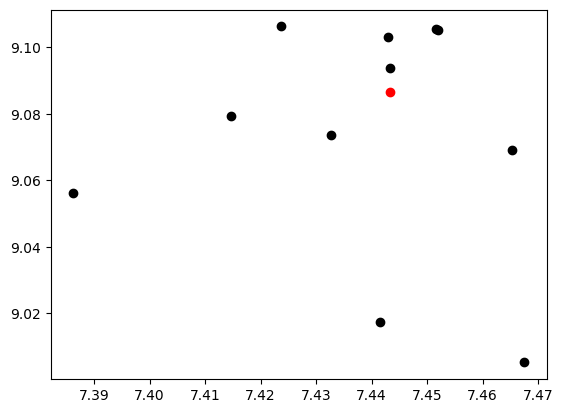

In [24]:
#plot of data points
plt.scatter(y=store_data["y"], x=store_data["x"], color="black")
plt.scatter(y=start[0], x=start[1], color="red")
plt.show()

In [25]:
# setup data for visuals
data=pd.concat([store_data,farm_data])
#label pick up / drop off
i = 0
data["cat"] = data["id"].apply(lambda x: 1 if x==i else 0)
data=data.reset_index()
data

,index,id,location,y,x,cat
0,0,0,a,9.093711,7.443353,1
1,1,1,b,9.103119,7.442881,0
2,2,2,c,9.105365,7.451936,0
3,3,3,d,9.073794,7.432667,0
4,4,4,e,9.069217,7.465369,0
5,5,5,f,9.079346,7.414686,0
6,6,6,g,9.106307,7.423621,0
7,7,7,h,9.017394,7.441473,0
8,8,8,i,9.005272,7.467480,0
9,9,9,j,9.105453,7.451601,0


In [26]:
#remove duplicate pick up (cat =1) for now
data1=data.drop([0]).reset_index()
data1

,level_0,index,id,location,y,x,cat
0,1,1,1,b,9.103119,7.442881,0
1,2,2,2,c,9.105365,7.451936,0
2,3,3,3,d,9.073794,7.432667,0
3,4,4,4,e,9.069217,7.465369,0
4,5,5,5,f,9.079346,7.414686,0
5,6,6,6,g,9.106307,7.423621,0
6,7,7,7,h,9.017394,7.441473,0
7,8,8,8,i,9.005272,7.467480,0
8,9,9,9,j,9.105453,7.451601,0
9,10,10,10,k,9.056348,7.386211,0


In [27]:
#setting up map display on folium
  
# base map
map = folium.Map(location=start, tiles="cartodbpositron", zoom_start=11)

#setup
color = "cat"  #color based on this column
lst_colors = ["green","red"]
popup = "id" #popup based on this column
  
# add colors
lst_elements = sorted(list(data1[color].unique()))
data1["color"] = data[color].apply(lambda x: 
                  lst_colors[lst_elements.index(x)])

# add popup
data1.apply(lambda row: 
    folium.CircleMarker(
            location=[row["y"],row["x"]], popup=row[popup],
            color=row["color"], fill=True, radius=5).add_to(map), 
    axis=1)

# add full-screen button
plugins.Fullscreen(position="topright", title="Expand", 
      title_cancel="Exit", force_separate_button=True).add_to(map)

# show
map

In [28]:
# add lines
for i in range(len(data1)):
    points = [start, data1[["y","x"]].iloc[i].tolist()]
    folium.PolyLine(points, tooltip="Coast", color="red", 
                    weight=0.5, opacity=0.5).add_to(map)

map

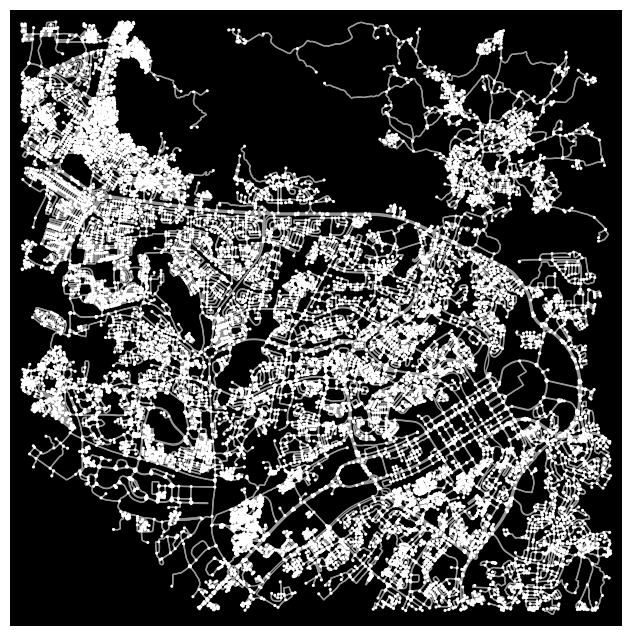

In [29]:
# create network graph
G = ox.graph_from_point(start, dist=10000, 
        network_type="drive")  #'drive', 'bike', 'walk'
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# plot
fig, ax = ox.plot_graph(G, bgcolor="black", node_size=5, 
        node_color="white", figsize=(16,8))

In [30]:
# geo-dataframe (nodes)
print("nodes:", len(G.nodes()))
ox.graph_to_gdfs(G, nodes=True, edges=False).reset_index().head(3)

nodes: 16876


,osmid,y,x,street_count,highway,geometry
0,31384670,9.051983,7.483308,3,NaN,POINT (7.48331 9.05198)
1,31384721,9.058040,7.497374,3,NaN,POINT (7.49737 9.05804)
2,31416145,9.062721,7.496355,3,NaN,POINT (7.49636 9.06272)


In [31]:
# geo-dataframe (links)
print("links:", len(G.edges()))
ox.graph_to_gdfs(G, nodes=False, edges=True).reset_index().head(3)

links: 39966


,u,v,key,osmid,highway,oneway,reversed,length,speed_kph,travel_time,geometry,lanes,name,access,bridge,maxspeed,ref,junction,tunnel
0,31384670,5588783853,0,584727037,residential,False,True,210.281,32.1,23.6,"LINESTRING (7.48331 9.05198, 7.48493 9.05300)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,31384670,1994601491,0,4844937,unclassified,False,False,208.889,100.0,7.5,"LINESTRING (7.48331 9.05198, 7.48330 9.05200, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,31384670,1293307708,0,4844937,unclassified,False,True,392.330,100.0,14.1,"LINESTRING (7.48331 9.05198, 7.48389 9.05108, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
data1=data1[['id','location','y','x','cat']]
data1.head()

,id,location,y,x,cat
0,1,b,9.103119,7.442881,0
1,2,c,9.105365,7.451936,0
2,3,d,9.073794,7.432667,0
3,4,e,9.069217,7.465369,0
4,5,f,9.079346,7.414686,0


In [33]:
end = data1[data1["id"]==3][["y","x"]].values[0]
print("locations: from", start, "--> to", end)

locations: from [9.08660288 7.44327827] --> to [9.07379411 7.4326674 ]


In [34]:
start_node = ox.distance.nearest_nodes(G, start[1], start[0])
end_node = ox.distance.nearest_nodes(G, end[1], end[0])
print("nodes: from", start_node, "--> to", end_node)

nodes: from 5601109574 --> to 1831017015


[5601109574, 1807901221, 5603331529, 5601609386, 1831056827, 1831056701, 1831056666, 4239944948, 5593722871, 5593722873, 5593554712, 2242652324, 2242650952, 1831017063, 1853178121, 1831017059, 1831017015]


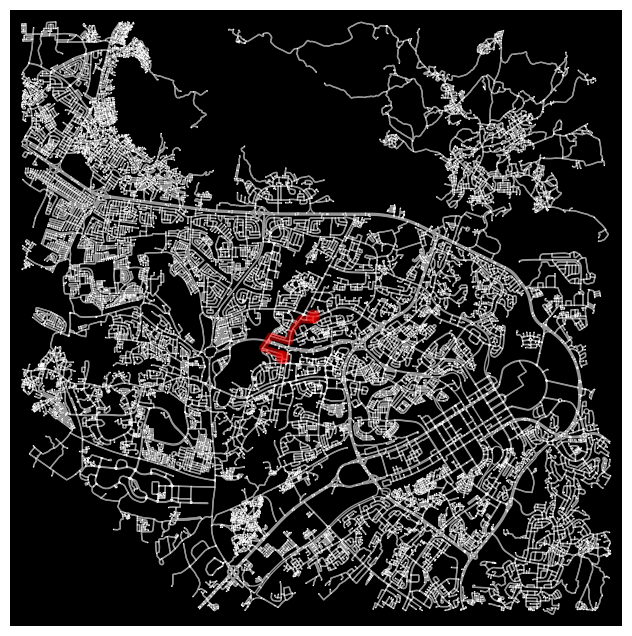

In [35]:
# calculate shortest path
path_lenght = nx.shortest_path(G, source=start_node, target=end_node, 
                                method='dijkstra', weight='lenght')     
print(path_lenght)

# plot on the graph
fig, ax = ox.plot_graph_route(G, path_lenght, route_color="red", 
                              route_linewidth=5, node_size=1, 
                              bgcolor='black', node_color="white", 
                              figsize=(16,8))

### preprocessing for multiple locations

In [36]:
import sklearn
## get the node for each location

data1["node"] = data1[["y","x"]].apply(lambda x: 
                           ox.distance.nearest_nodes(G, x[1], x[0]), 
                        axis=1)
data1 = data1.drop_duplicates("node", keep='first')
data1.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_24380\4250954702.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ox.distance.nearest_nodes(G, x[1], x[0]),
C:\Users\HP\AppData\Local\Temp\ipykernel_24380\4250954702.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ox.distance.nearest_nodes(G, x[1], x[0]),
C:\Users\HP\AppData\Local\Temp\ipykernel_24380\4250954702.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ox.distance.nearest_no

,id,location,y,x,cat,node
0,1,b,9.103119,7.442881,0,5564483055
1,2,c,9.105365,7.451936,0,6913063713
2,3,d,9.073794,7.432667,0,1831017015
3,4,e,9.069217,7.465369,0,6914485848
4,5,f,9.079346,7.414686,0,1831045345


In [37]:
## distance length function
def f(a,b):
    try:
        d = nx.shortest_path_length(G, source=a, target=b, 
                                    method='dijkstra', 
                                    weight='travel_time')
    except:
        d = np.nan
    return d


## apply the function
distance_matrix = np.asarray([[f(a,b) for b in data1["node"].tolist()] 
                               for a in data1["node"].tolist()])
distance_matrix = pd.DataFrame(distance_matrix, 
                               columns=data1["node"].values, 
                               index=data1["node"].values)
distance_matrix.head()

,5564483055,6913063713,1831017015,6914485848,1831045345,1831081099,5393678128,1830943719,5594695873,2223524196,5601109574
5564483055,0.0,402.9,557.8,608.1,459.8,575.2,887.3,957.6,406.4,594.6,429.8
6913063713,578.4,0.0,387.7,355.4,366.4,534.1,634.6,704.9,4.2,556.1,187.2
1831017015,547.0,345.5,0.0,202.3,289.0,502.7,423.8,494.1,341.3,332.3,152.5
6914485848,629.6,334.0,212.5,0.0,268.9,507.1,372.8,443.1,338.2,450.3,216.2
1831045345,437.9,405.6,170.3,276.3,0.0,313.3,544.3,614.6,401.4,268.5,212.6


In [38]:
# fillna with row average
distance_matrix = distance_matrix.T.fillna(distance_matrix.mean(axis=1)).T

# fillna with overall average
distance_matrix = distance_matrix.fillna(distance_matrix.mean().mean())


### Travelling Sales Man Problem

In [39]:
## Business parameters
drivers = 1

lst_nodes = data1["node"].tolist()
print("start:", start_node, "| tot locations to visit:", 
     len(lst_nodes)-1, "| drivers:", drivers)

start: 5601109574 | tot locations to visit: 10 | drivers: 1


In [40]:
manager = pywrapcp.RoutingIndexManager(len(lst_nodes), 
                                       drivers, 
                                       lst_nodes.index(start_node))
model = pywrapcp.RoutingModel(manager)

## Add Cost Function For Each Step

In [41]:
#add cost function for each step which will be minimized. In our case, it’s the distance
def get_distance(from_index, to_index):
    return distance_matrix.iloc[from_index,to_index]

distance = model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

##set strategy
parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy = (
          routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)

# Solving The Problem

In [42]:
solution = model.SolveWithParameters(parameters)

index = model.Start(0)
print('Route for driver:')
route_idx, route_distance = [], 0
while not model.IsEnd(index):
    route_idx.append( manager.IndexToNode(index) ) 
    previous_index = index
    index = solution.Value( model.NextVar(index) )
    ### update distance
    try:
        route_distance += get_distance(previous_index, index)
    except:
        route_distance += model.GetArcCostForVehicle(
                              from_index=previous_index, 
                              to_index=index, 
                              vehicle=0)

print(route_idx)
print(f'Total distance: {round(route_distance/1000,2)} km')
print(f'Nodes visited: {len(route_idx)}')

Route for driver:
[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
Total distance: 4.41 km
Nodes visited: 11


In [43]:
#transform nodes from sequence of indexes to a sequence of nodes
print("Route for driver (nodes):")
lst_route = [lst_nodes[i] for i in route_idx]
print(lst_route)

Route for driver (nodes):
[5601109574, 2223524196, 5594695873, 1830943719, 5393678128, 1831081099, 1831045345, 6914485848, 1831017015, 6913063713, 5564483055]


# Visualize Route

In [45]:
# Get path between nodes
def get_path_between_nodes(lst_route):
    lst_paths = []
    for i in range(len(lst_route)):
        try:
            a, b = lst_nodes[i], lst_nodes[i+1]
        except:
            break
        try:
            path = nx.shortest_path(G, source=a, target=b, 
                                    method='dijkstra', 
                                    weight='travel_time')
            if len(path) > 1:
                lst_paths.append(path)
        except:
            continue
    return lst_paths

lst_paths = get_path_between_nodes(lst_route)


# Add paths on the map
for path in lst_paths:
    ox.plot_route_folium(G, route=path, route_map=map, 
                         color="blue", weight=1)
map

C:\Users\HP\AppData\Local\Temp\ipykernel_24380\2222396091.py:24: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.plot_route_folium(G, route=path, route_map=map,
C:\Users\HP\AppData\Local\Temp\ipykernel_24380\2222396091.py:24: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.plot_route_folium(G, route=path, route_map=map,
C: